Check the integrity of all merged files

In [1]:
import harp
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
ROOT = "/Volumes/KINGSTON/Thesis/thesis-no2/Data/"
ROOT = "../../Data/"

# Open aoi.json
with open(f"{ROOT}aoi.json", "r") as f:
    aoi = json.load(f)


# Info about downloaded orbits

First check if all variables are in the orbits

In [3]:
# create variable list from variables.txt where each line is a variable
with open("variables.txt", "r") as f:
    variables = f.read().splitlines()

In [4]:
def in_catalog(file, download_list):
    # orbit_id is the last part of the filename
    orbit_id = file.split("\\")[-1].split(".")[0]
    
    # check if orbit_id has all products in download_list
    orbit_df = download_list[download_list["sat:absolute_orbit"] == int(orbit_id)]
    if not set(orbit_df["s5p:type"].values) == set(['HCHO', 'NO2', 'SO2']):
        print(f"Missing products for {file}")
    elif orbit_df["coverage"].min() < 1:
        print(f"Coverage less than 1 for {file}")
    else:
        return

In order to continue, we need more information about the orbits. For example, we need to know the importance of time. Make distributions to have more insight into the data

In [5]:

# Store lengths for each AOI
lengths = {}
time_std = {}
no2_nan = {}
n_variables = {}

for aoi_name, area_of_interest in aoi.items():
    path = f"{ROOT}TinyEODATA/{aoi_name}/Sentinel-5P/TROPOMI/L3__Merged_/"

    files = glob.glob(os.path.join(path, "*/*/*/*.nc"))
    lengths[aoi_name] = []  # Store lengths for this AOI
    time_std[aoi_name] = []  # Store time std for this AOI
    no2_nan[aoi_name] = []  # Store no2 nan for this AOI
    n_variables = []
    meridional_wind_arr = []
    zonal_wind_arr = []

    download_list = pd.read_csv(f"{ROOT}Catalog/{aoi_name}/download_list.csv")

    for file in files:
        in_catalog(file, download_list)
        try:
            orbit = harp.import_product(file)
        # except CLibraryError:
        except:
            print(f"Error with file: {file}")
            continue
        n_variables.append(len(orbit))
        if len(orbit) != 78:
            print(f"Error with file: {file}, n_variables = {len(orbit)}")
        lengths[aoi_name].append(orbit.datetime_start.data.shape[0])
        try:
            no2_nan[aoi_name].append(np.count_nonzero(np.isnan(orbit.NO2_slant_column_number_density.data)))
        except AttributeError:
            print(f"Error with file: {file}, no2")
        time_normalized = orbit.datetime_start.data - orbit.datetime_start.data.min() + orbit.datetime_length.data
        time_std[aoi_name].append(time_normalized.std() / 60) # in minutes
        meridional_wind_arr.append(orbit.surface_meridional_wind_velocity.data.std())
        zonal_wind_arr.append(orbit.surface_zonal_wind_velocity.data.std())

Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\08\2938.nc, n_variables = 19
Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\09\2952.nc, n_variables = 19
Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\10\2966.nc, n_variables = 19
Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\11\2980.nc, n_variables = 19
Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\12\2995.nc, n_variables = 19
Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\13\3009.nc, n_variables = 19
Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\14\3023.nc, n_variables = 19
Error with file: ../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\2018\05\16\3051.nc, n_variables = 19
Error with file: ../../D

`{'SO2_layer_height_validity', 'SO2_layer_pressure', 'SO2_layer_height', 'SO2_layer_height_uncertainty'}` seems to be missing from all merged orbits. These variables are not essential, so we can just ignore this

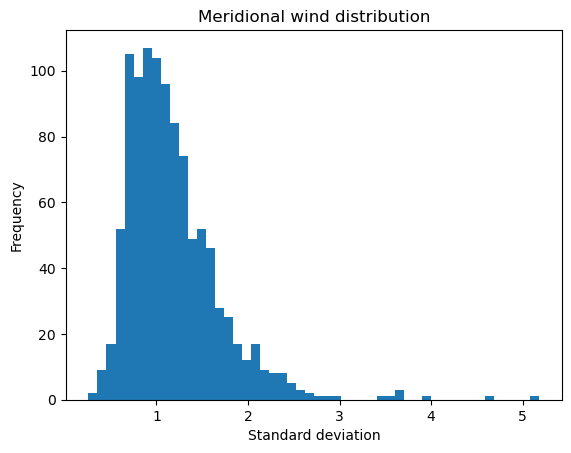

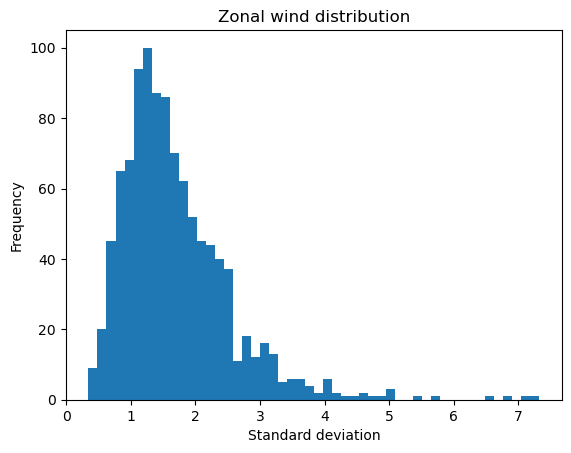

In [11]:
# plot the meridional wind distribution
plt.hist(meridional_wind_arr, bins=50)
plt.title("Meridional wind distribution")
plt.xlabel("Standard deviation")
plt.ylabel("Frequency")
plt.show()

# plot the zonal wind distribution
plt.hist(zonal_wind_arr, bins=50)
plt.title("Zonal wind distribution")
plt.xlabel("Standard deviation")
plt.ylabel("Frequency")
plt.show()

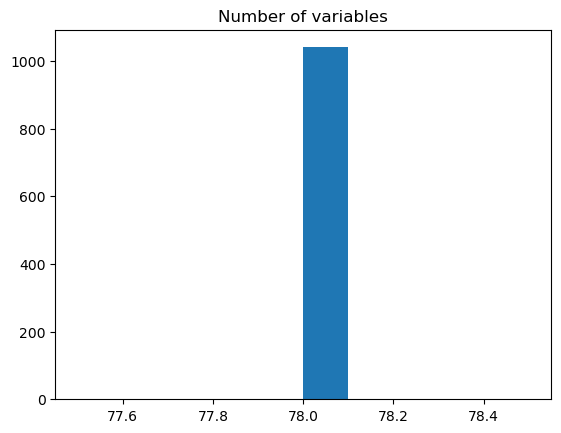

In [12]:
# plot the number of variables
plt.hist(n_variables)
plt.title("Number of variables")
plt.show()

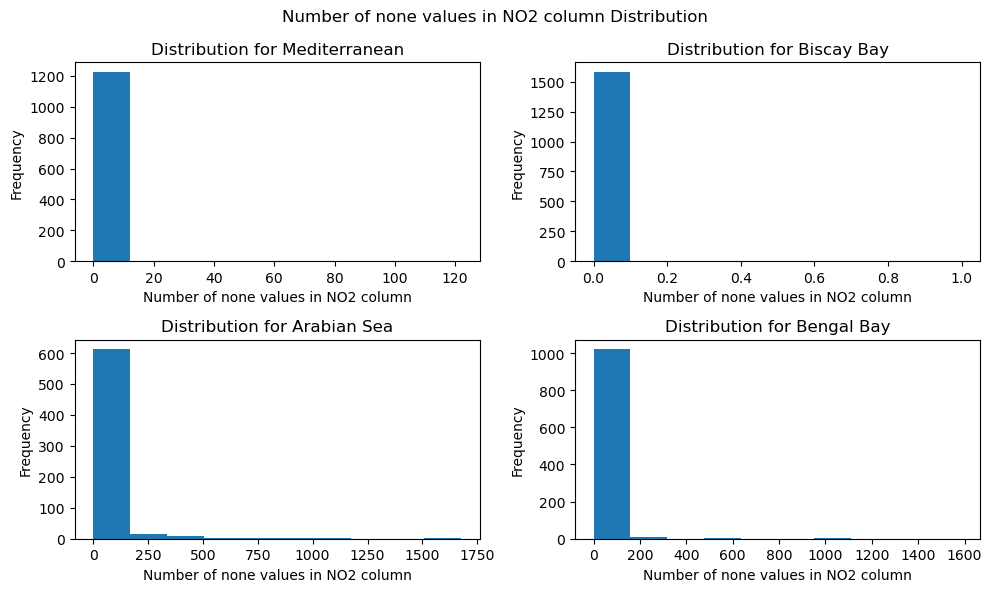

In [13]:
# Plotting number of data points distribution
num_aois = len(aoi)
cols = 2  # Adjust columns if needed
rows = num_aois // cols + (num_aois % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))  # Adjust figsize

for i, (aoi_name, data) in enumerate(no2_nan.items()):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]  # Handle single row case

    ax.hist(data)
    ax.set_xlabel("Number of none values in NO2 column")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution for {aoi_name}")
    # add labels to each bar

# add title for the whole plot
fig.suptitle("Number of none values in NO2 column Distribution")
fig.tight_layout()
plt.show()

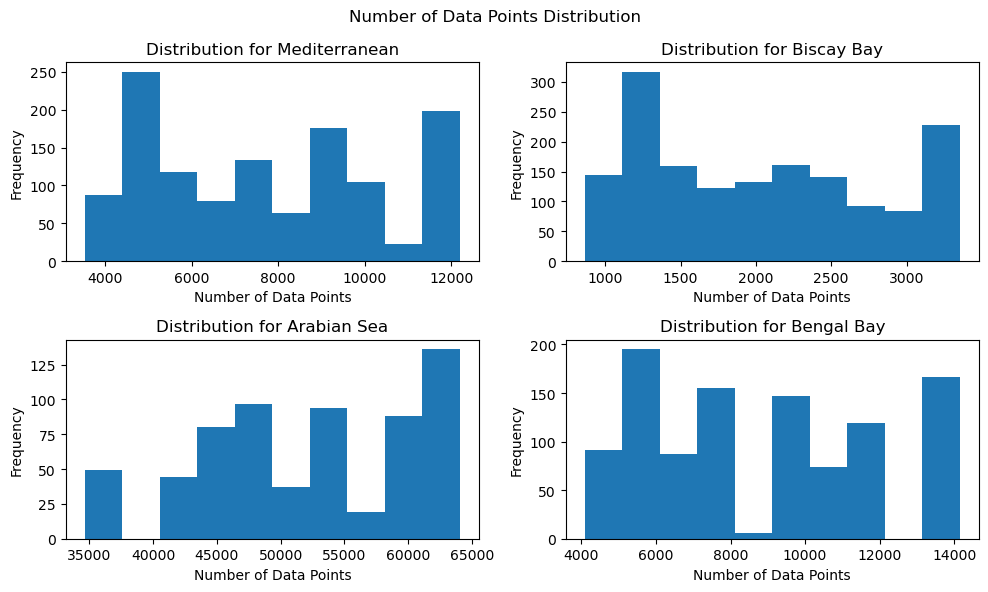

In [14]:
# Plotting number of data points distribution
num_aois = len(aoi)
cols = 2  # Adjust columns if needed
rows = num_aois // cols + (num_aois % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))  # Adjust figsize

for i, (aoi_name, data) in enumerate(lengths.items()):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]  # Handle single row case

    ax.hist(data)
    ax.set_xlabel("Number of Data Points")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution for {aoi_name}")

# add title for the whole plot
fig.suptitle("Number of Data Points Distribution")
fig.tight_layout()
plt.show()

These distribution tells us that the number of samples can differ greatly for each orbit filtered on AOI.

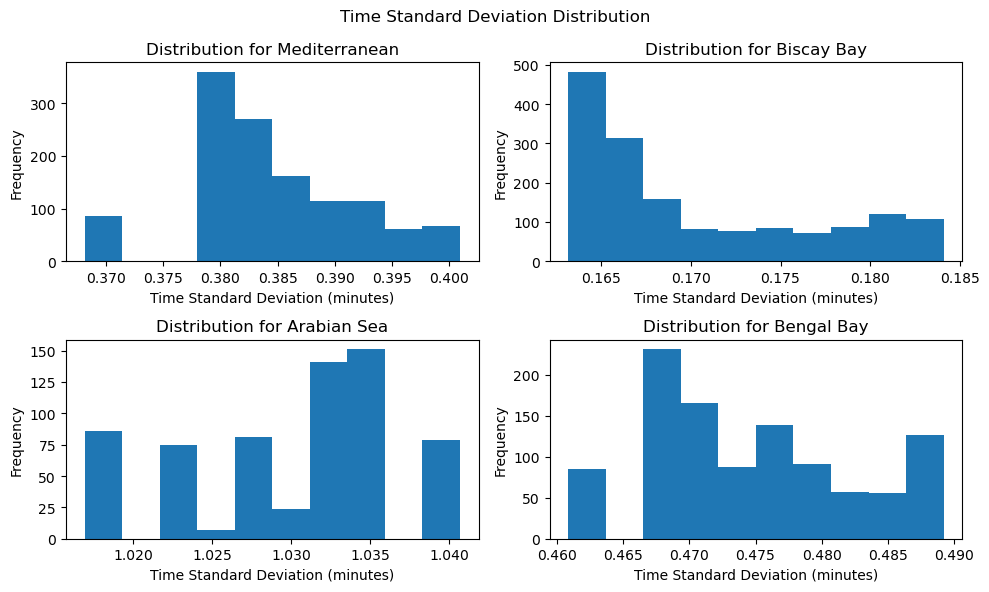

In [15]:
# plotting time standard deviation
num_aois = len(aoi)
cols = 2  # Adjust columns if needed
rows = num_aois // cols + (num_aois % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))  # Adjust figsize

for i, (aoi_name, data) in enumerate(time_std.items()):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]  # Handle single row case

    ax.hist(data)
    ax.set_xlabel("Time Standard Deviation (minutes)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution for {aoi_name}")
    
# add title for the whole plot
fig.suptitle("Time Standard Deviation Distribution")
fig.tight_layout()
plt.show()

The standard deviation tells us that most values only differ up to a minute. The TROPOMI gridd cells are XxY km, the ship won't be able to travel more than one grid cell. therefore, we can take the average time for querying AIS data. This will add some noise, but will speed up the process.

# Azimuth angles

In [21]:

# Store lengths for each AOI
sensor_azimuth_angle = []
solar_azimuth_angle = []    
path = "../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_/*/*/*/*.nc"
files = glob.glob(path)
print(len(files))
orbit = harp.import_product(files, operations="keep(sensor_azimuth_angle, solar_azimuth_angle)")
print(orbit)        
        

1233
history = "2024-04-04T11:26:17Z [harp-1.20.2] harp.import_product('E:/thesis dump/EODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\\2018\\05\\08\\2938.nc',operations='latitude>=33.2;latitude<=38;longitude>=14;longitude<=19.3;keep(HCHO_slant_column_number_density,tropospheric_HCHO_column_number_density_validity,NO2_slant_column_number_density,tropospheric_NO2_column_number_density_validity,SO2_slant_column_number_density,SO2_column_number_density_validity,datetime_start,datetime_length,latitude,longitude,cloud_fraction,surface_meridional_wind_velocity,surface_zonal_wind_velocity,latitude_bounds,longitude_bounds,solar_zenith_angle,sensor_zenith_angle,solar_azimuth_angle,sensor_azimuth_angle)')\n2024-09-17T11:09:16Z [harp-1.20.2] harp.import_product('../../Data/TinyEODATA/Mediterranean/Sentinel-5P/TROPOMI/L3__Merged_\\2022\\07\\24\\24758.nc',operations='keep(sensor_azimuth_angle, solar_azimuth_angle)')"

float solar_azimuth_angle {time=9524656} [degree]
float sensor_azimuth_angle

In [26]:
print(min(orbit.sensor_azimuth_angle.data))
print(max(orbit.sensor_azimuth_angle.data))

print(min(orbit.solar_azimuth_angle.data))
print(max(orbit.solar_azimuth_angle.data))

-108.6709
84.531715
-179.99965
179.99995
